In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
from multiprocessing import Pool
from tqdm import tqdm
import json
from sklearn.metrics import roc_auc_score, average_precision_score

In [2]:
# Load the variables
with open('./utils/variables.json', 'r') as file:
    variables = json.load(file)

SCR_feature_space = variables['SCR_feature_space']
LAB_feature_space = variables['LAB_feature_space']
train_len = variables['train_len']
test_len = variables['test_len']
print(len(SCR_feature_space), len(LAB_feature_space))
print(train_len, test_len)

7 40
8637 8542


In [3]:
# get num_processors for parallel computing
num_processors = multiprocessing.cpu_count()

TODOs:
1. Finish the following codes
2. Finish the external validation
3. Sliding the internal validation window and derive p values (Only for the final model)
4. Test on sub-groups (radar plots)
5. If time permitted, set one-week after discharge mortality prediction for AKI patients
6. Sensitivity analysis

# Preprocess Dataset

In [4]:
# read onset dadaset
dataset = pd.read_csv("/blue/yonghui.wu/lideyi/Personalization_Methodology/dataset.csv")
# make sure the index is ordered
dataset = dataset.reset_index(drop=True)
assert len(dataset) == train_len + test_len

In [5]:
data_train = dataset.iloc[:train_len, :].copy(deep = True)
data_test = dataset.iloc[train_len:, :].copy(deep = True)

# Run DTW with Missing Values

Since DTW-AROW does not require missing data imputation, we run it first. Then we impute the data and run normalization.

In [6]:
import sys
sys.path.append('/home/lideyi/AKI_SMART/SMART/DTW_with_missing_values')
import dtw_missing.dtw_missing as dtw_m
from utils.Z_Helping_Functions import translate_dist_mtx_to_simi, fast_argsort, min_max_normalization

In [7]:
# for SCR we do not apply the same normalization as LAB, since the values are already in the same range (unit)
SCR_full = dataset.loc[:, SCR_feature_space].copy(deep = True)

In [8]:
def parallel_distance_matrix(df: pd.DataFrame, num_processes: int, metric: callable) -> np.ndarray:
    pool = Pool(num_processes)
    total = len(df)

    results = list(tqdm(pool.imap(calculate_overlap, [(i, df, metric) for i in range(total - 1)]), total=total - 1))
    pool.close()
    pool.join()
    distance_mtx = create_distance_matrix(results)
    return distance_mtx

In [9]:
def calculate_overlap(args: tuple) -> list:
    index, df, metric = args
    return [metric(df.iloc[index], df.iloc[j]) for j in range(index + 1, len(df))]

In [10]:
def create_distance_matrix(distance_list: list) -> np.array:
    n = len(distance_list[0]) + 1

    matrix = np.zeros((n, n))

    for i in range(n-1):
        matrix[i, i+1:i+1+len(distance_list[i])] = distance_list[i]

    for i in range(n):
        for j in range(i+1, n):
            matrix[j, i] = matrix[i, j]
    return matrix

In [11]:
def get_DTW_distance(u, v):
    u = np.array(u)
    v = np.array(v)
    d = dtw_m.warping_paths(u, v)[0]
    return d

In [12]:
# SCR_DTW_dist_full = parallel_distance_matrix(SCR_full, num_processors, get_DTW_distance)
# np.save('/blue/yonghui.wu/lideyi/Personalization_Methodology/SCR_DTW_dist_imput2.npy', SCR_DTW_dist_full)

In [13]:
SCR_DTW_dist_full = np.load('/blue/yonghui.wu/lideyi/Personalization_Methodology/SCR_DTW_dist_imput2.npy')

In [14]:
# transfrom distance mtx to similarity score mtx by min-max normalization and substration from 1
SCR_DTW_simi_full = translate_dist_mtx_to_simi(SCR_DTW_dist_full)
# sort similarity score mtx into idx matrix by most similar rank highest. This is for the entire dataset, train + test
SCR_DTW_idx_full = fast_argsort(SCR_DTW_simi_full, num_processors)

In [15]:
# get the similarity matrix and idx rankings only for train set, this is for the one-vs-all training
SCR_DTW_dist_train = SCR_DTW_dist_full[:len(data_train), :len(data_train)]
SCR_DTW_simi_train = translate_dist_mtx_to_simi(SCR_DTW_dist_train)
SCR_DTW_idx_train = fast_argsort(SCR_DTW_simi_train, num_processors)

# Impute SCR and LAB Missing Values Respectively

In [16]:
# SCR, since it just row wise we do not need to split into train and test
SCR_full = SCR_full.interpolate(method='linear', axis = 1)
SCR_full = SCR_full.bfill(axis=1)
SCR_full = SCR_full.ffill(axis=1)

In [17]:
# after imputation, we can safely split into train and test
SCR_train = SCR_full.iloc[:train_len, :].copy(deep = True)
SCR_test = SCR_full.iloc[train_len:, :].copy(deep = True)

In [18]:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

In [19]:
# it is of note that the imputation is done on the lab train and lab test separately
# this is to avoid data leakage
LAB_train = data_train.loc[:, LAB_feature_space].copy(deep = True)
LAB_test = data_test.loc[:, LAB_feature_space].copy(deep = True)

In [20]:
# lab normalization
LAB_train = (LAB_train - LAB_train.min(skipna=True)) / (LAB_train.max(skipna=True) - LAB_train.min(skipna=True))
LAB_test = (LAB_test - LAB_test.min(skipna=True)) / (LAB_test.max(skipna=True) - LAB_test.min(skipna=True))
# impute lab missing values
imputer = IterativeImputer(missing_values=np.nan, max_iter=1000, random_state=42)
imputer.fit(LAB_train)
LAB_train_temp = imputer.transform(LAB_train)
LAB_test_temp = imputer.transform(LAB_test)
LAB_train.loc[:, :] = LAB_train_temp
LAB_test.loc[:, :] = LAB_test_temp
# Concate train and test
LAB_full = pd.concat([LAB_train, LAB_test], axis = 0)


# Euclidean, Cosine and Manhattan Matrix of SCR and LAB

In [21]:
from sklearn.metrics import pairwise_distances

In [22]:
def compute_similarity(feature_df: pd.DataFrame, metric: str, train_len: int, num_processors: int) -> \
    tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    if metric in ['euclidean', 'cosine', 'manhattan']:
        # compute the distance matrix for the entire dataset
        dist_full_arr = pairwise_distances(feature_df, metric=metric, n_jobs=-1)
        simi_full_arr = translate_dist_mtx_to_simi(dist_full_arr)
        idx_full_arr = fast_argsort(simi_full_arr, num_processors)
        
        # we also need to compute the similarity matrix and idx rankings only for the train set
        dist_train_arr = dist_full_arr[:train_len, :train_len]
        simi_train_arr = translate_dist_mtx_to_simi(dist_train_arr)
        idx_train_arr = fast_argsort(simi_train_arr, num_processors)
        
    else:
        raise ValueError('Invalid metric')
    return simi_full_arr, idx_full_arr, simi_train_arr, idx_train_arr

In [23]:
# SCR
# Euclidean
SCR_Euc_simi_full, SCR_Euc_idx_full, SCR_Euc_simi_train, SCR_Euc_idx_train = compute_similarity(SCR_full, 'euclidean', train_len, num_processors)
# Cosine
SCR_Cos_simi_full, SCR_Cos_idx_full, SCR_Cos_simi_train, SCR_Cos_idx_train = compute_similarity(SCR_full, 'cosine', train_len, num_processors)
# Manhattan
SCR_Manh_simi_full, SCR_Manh_idx_full, SCR_Manh_simi_train, SCR_Manh_idx_train = compute_similarity(SCR_full, 'manhattan', train_len, num_processors)

In [24]:
# LAB
# Euclidean
LAB_Euc_simi_full, LAB_Euc_idx_full, LAB_Euc_simi_train, LAB_Euc_idx_train = compute_similarity(LAB_full, 'euclidean', train_len, num_processors)
# Cosine
LAB_Cos_simi_full, LAB_Cos_idx_full, LAB_Cos_simi_train, LAB_Cos_idx_train = compute_similarity(LAB_full, 'cosine', train_len, num_processors)
# Manhattan
LAB_Manh_simi_full, LAB_Manh_idx_full, LAB_Manh_simi_train, LAB_Manh_idx_train = compute_similarity(LAB_full, 'manhattan', train_len, num_processors)

In [25]:
# simi here is the un-ordered, normalized similarity score matrix, idx is the ordered paitent index matrix
# nw stands for not weighted by data overlap rates matrix
nw_fea_arrs_dict = {"SCR": {"DTW": {"simi": {"full": SCR_DTW_simi_full, "train": SCR_DTW_simi_train}, "idx": {"full": SCR_DTW_idx_full, "train": SCR_DTW_idx_train}}, 
                            "Euc": {"simi": {"full": SCR_Euc_simi_full, "train": SCR_Euc_simi_train}, "idx": {"full": SCR_Euc_idx_full, "train": SCR_Euc_idx_train}}, 
                            "Cos": {"simi": {"full": SCR_Cos_simi_full, "train": SCR_Cos_simi_train}, "idx": {"full": SCR_Cos_idx_full, "train": SCR_Cos_idx_train}}, 
                            "Manh":{"simi": {"full": SCR_Manh_simi_full, "train": SCR_Manh_simi_train}, "idx": {"full": SCR_Manh_idx_full, "train": SCR_Manh_idx_train}}}, 
                    "LAB": {"Euc": {"simi": {"full": LAB_Euc_simi_full, "train": LAB_Euc_simi_train}, "idx": {"full": LAB_Euc_idx_full, "train": LAB_Euc_idx_train}}, 
                            "Cos": {"simi": {"full": LAB_Cos_simi_full, "train": LAB_Cos_simi_train}, "idx": {"full": LAB_Cos_idx_full, "train": LAB_Cos_idx_train}}, 
                            "Manh":{"simi": {"full": LAB_Manh_simi_full, "train": LAB_Manh_simi_train}, "idx": {"full": LAB_Manh_idx_full, "train": LAB_Manh_idx_train}}}}

# Data Overlap Rates Weighting

We weight previously-computed patient similarity matrix by data overlap rates matrix, normalized and re-order the similar patient index matrix.

In [27]:
# read pre-computed pairwise data overlap rates
SCR_overlap_full = np.load('/blue/yonghui.wu/lideyi/Personalization_Methodology/SCR_overlap.npy')
LAB_overlap_full = np.load('/blue/yonghui.wu/lideyi/Personalization_Methodology/lab_overlap.npy')

In [28]:
# consequently, we will only use the upper-left block of the overlap rate mtx for one-vs-all training
SCR_overlap_train = SCR_overlap_full[:train_len, :train_len]
LAB_overlap_train = LAB_overlap_full[:train_len, :train_len]

In [29]:
def overlap_rates_weighting(overlap_arr, simi_arr, num_processors):
    weighted_simi_arr = overlap_arr * simi_arr
    weighted_idd_arr = fast_argsort(weighted_simi_arr, num_processors)
    return weighted_simi_arr, weighted_idd_arr

In [30]:
# on full data (for testing)
# SCR
SCR_DTW_simi_wt_full, SCR_DTW_idx_wt_full = overlap_rates_weighting(SCR_overlap_full, nw_fea_arrs_dict["SCR"]["DTW"]["simi"]["full"], num_processors)
SCR_Euc_simi_wt_full, SCR_Euc_idx_wt_full = overlap_rates_weighting(SCR_overlap_full, nw_fea_arrs_dict["SCR"]["Euc"]["simi"]["full"], num_processors)
SCR_Cos_simi_wt_full, SCR_Cos_idx_wt_full = overlap_rates_weighting(SCR_overlap_full, nw_fea_arrs_dict["SCR"]["Cos"]["simi"]["full"], num_processors)
SCR_Manh_simi_wt_full, SCR_Manh_idx_wt_full = overlap_rates_weighting(SCR_overlap_full, nw_fea_arrs_dict["SCR"]["Manh"]["simi"]["full"], num_processors)

# LAB
LAB_Euc_simi_wt_full, LAB_Euc_idx_wt_full = overlap_rates_weighting(LAB_overlap_full, nw_fea_arrs_dict["LAB"]["Euc"]["simi"]["full"], num_processors)
LAB_Cos_simi_wt_full, LAB_Cos_idx_wt_full = overlap_rates_weighting(LAB_overlap_full, nw_fea_arrs_dict["LAB"]["Cos"]["simi"]["full"], num_processors)
LAB_Manh_simi_wt_full, LAB_Manh_idx_wt_full = overlap_rates_weighting(LAB_overlap_full, nw_fea_arrs_dict["LAB"]["Manh"]["simi"]["full"], num_processors)

In [31]:
# on training data (for one-vs-all training)
# SCR
SCR_DTW_simi_wt_train, SCR_DTW_idx_wt_train = overlap_rates_weighting(SCR_overlap_train, nw_fea_arrs_dict["SCR"]["DTW"]["simi"]["train"], num_processors)
SCR_Euc_simi_wt_train, SCR_Euc_idx_wt_train = overlap_rates_weighting(SCR_overlap_train, nw_fea_arrs_dict["SCR"]["Euc"]["simi"]["train"], num_processors)
SCR_Cos_simi_wt_train, SCR_Cos_idx_wt_train = overlap_rates_weighting(SCR_overlap_train, nw_fea_arrs_dict["SCR"]["Cos"]["simi"]["train"], num_processors)
SCR_Manh_simi_wt_train, SCR_Manh_idx_wt_train = overlap_rates_weighting(SCR_overlap_train, nw_fea_arrs_dict["SCR"]["Manh"]["simi"]["train"], num_processors)

# LAB
LAB_Euc_simi_wt_train, LAB_Euc_idx_wt_train = overlap_rates_weighting(LAB_overlap_train, nw_fea_arrs_dict["LAB"]["Euc"]["simi"]["train"], num_processors)
LAB_Cos_simi_wt_train, LAB_Cos_idx_wt_train = overlap_rates_weighting(LAB_overlap_train, nw_fea_arrs_dict["LAB"]["Cos"]["simi"]["train"], num_processors)
LAB_Manh_simi_wt_train, LAB_Manh_idx_wt_train = overlap_rates_weighting(LAB_overlap_train, nw_fea_arrs_dict["LAB"]["Manh"]["simi"]["train"], num_processors)


In [32]:
# simi here is the un-ordered, normalized similarity score matrix, idx is the ordered paitent index matrix
# nw stands for not weighted by data overlap rates matrix
wt_fea_arrs_dict = {"SCR": {"DTW": {"simi": {"full": SCR_DTW_simi_wt_full, "train": SCR_DTW_simi_wt_train}, "idx": {"full": SCR_DTW_idx_wt_full, "train": SCR_DTW_idx_wt_train}}, 
                            "Euc": {"simi": {"full": SCR_Euc_simi_wt_full, "train": SCR_Euc_simi_wt_train}, "idx": {"full": SCR_Euc_idx_wt_full, "train": SCR_Euc_idx_wt_train}}, 
                            "Cos": {"simi": {"full": SCR_Cos_simi_wt_full, "train": SCR_Cos_simi_wt_train}, "idx": {"full": SCR_Cos_idx_wt_full, "train": SCR_Cos_idx_wt_train}}, 
                            "Manh":{"simi": {"full": SCR_Manh_simi_wt_full, "train": SCR_Manh_simi_wt_train}, "idx": {"full": SCR_Manh_idx_wt_full, "train": SCR_Manh_idx_wt_train}}}, 
                    "LAB": {"Euc": {"simi": {"full": LAB_Euc_simi_wt_full, "train": LAB_Euc_simi_wt_train}, "idx": {"full": LAB_Euc_idx_wt_full, "train": LAB_Euc_idx_wt_train}}, 
                            "Cos": {"simi": {"full": LAB_Cos_simi_wt_full, "train": LAB_Cos_simi_wt_train}, "idx": {"full": LAB_Cos_idx_wt_full, "train": LAB_Cos_idx_wt_train}}, 
                            "Manh":{"simi": {"full": LAB_Manh_simi_wt_full, "train": LAB_Manh_simi_wt_train}, "idx": {"full": LAB_Manh_idx_wt_full, "train": LAB_Manh_idx_wt_train}}}}

# Optimize Distance Measures

In [34]:
# neighborhood sizes for optimizing best distance measures
k_sizes_train = [i for i in range(10, 201, 5)]
print(len(k_sizes_train))

39


For one-vs-all training, we need to remove the "one" index itself from its nearest neighbors.

In [35]:
# generate simi_dict for one-vs-all val
def process_idx_arr_for_optimizing(idx_arr: np.array, y_train: np.array) -> tuple[np.array, np.array]:
    idx_arr_clean = remove_row_idx(idx_arr)
    y_train_arr = sort_by_idx_arr(idx_arr_clean, y_train)
    return idx_arr_clean, y_train_arr

In [36]:
def remove_row_idx(idx_arr: np.array) -> np.array:    
    # Create a list to hold the new rows
    idx_arr_clean = []
    
    # Iterate through each row in the matrix
    for row_index in range(idx_arr.shape[0]):
        # Get the current row
        row = idx_arr[row_index]
        # Create a new row excluding the element equal to the row index
        new_row = row[row != row_index]
        # Append the new row to the new_matrix list
        idx_arr_clean.append(new_row)
    
    # Convert the list of rows back to a NumPy array
    idx_arr_clean = np.array(idx_arr_clean)
    
    return idx_arr_clean

In [37]:
def sort_by_idx_arr(idx_arr: np.array, y_train: np.array) -> np.array:
    y_train_arr = np.tile(y_train, (idx_arr.shape[0], 1))
    # Use advanced indexing to select the elements from matrix_b
    row_indices = np.arange(idx_arr.shape[0])[:, None]  # Create an array of row indices
    y_train_arr = y_train_arr[row_indices, idx_arr]  # Use the row indices and matrix_a for advanced indexing
    
    return y_train_arr

In [38]:
y_train = np.array(data_train["AKI_LABEL"])

In [39]:
# SCR
SCR_idx_y_nw_dict_train = {}
SCR_idx_y_wt_dict_train = {}

for dist_measure, arrs in tqdm(nw_fea_arrs_dict["SCR"].items()):
    idx_arr_train_clean, y_train_arr = process_idx_arr_for_optimizing(arrs["idx"]["train"], y_train)
    SCR_idx_y_nw_dict_train[dist_measure] = {"idx": idx_arr_train_clean, "label": y_train_arr}
for dist_measure, arrs in tqdm(wt_fea_arrs_dict["SCR"].items()):
    idx_arr_train_clean, y_train_arr = process_idx_arr_for_optimizing(arrs["idx"]["train"], y_train)
    SCR_idx_y_wt_dict_train[dist_measure] = {"idx": idx_arr_train_clean, "label": y_train_arr}

100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


In [40]:
# Lab
LAB_idx_y_nw_dict_train = {}
LAB_idx_y_wt_dict_train = {}

for dist_measure, arrs in tqdm(nw_fea_arrs_dict["LAB"].items()):
    idx_arr_train_clean, y_train_arr = process_idx_arr_for_optimizing(arrs["idx"]["train"], y_train)
    LAB_idx_y_nw_dict_train[dist_measure] = {"idx": idx_arr_train_clean, "label": y_train_arr}
for dist_measure, arrs in tqdm(wt_fea_arrs_dict["LAB"].items()):
    idx_arr_train_clean, y_train_arr = process_idx_arr_for_optimizing(arrs["idx"]["train"], y_train)
    LAB_idx_y_wt_dict_train[dist_measure] = {"idx": idx_arr_train_clean, "label": y_train_arr}

100%|██████████| 3/3 [00:03<00:00,  1.11s/it]


Optimize the distance measure at each k.

In [41]:
def compare_distance_measures(clean_arrs_dict: dict, y_test: np.array, k_sizes: int) -> dict:
    
    best_method_each_k = {"name": [], "AUPRC": []}
    
    for k in tqdm(k_sizes):
        
        best_method_name = ''
        best_method_AUPRC = 0
        
        for name, arr_dict in clean_arrs_dict.items():
            AUPRC, _ = KNN(arr_dict, k, y_test)
            
            # if better AUPRC, update
            if AUPRC > best_method_AUPRC:
                best_method_name = name
                best_method_AUPRC = AUPRC
                
        best_method_each_k["name"].append(best_method_name)
        best_method_each_k["AUPRC"].append(best_method_AUPRC)
    
    return best_method_each_k    

In [42]:
#return AUROC and AUPRC at a certain size k
def KNN(arr_dict: dict, k: int, y_test: np.array) -> tuple[float, float]:
    y_train_arr = arr_dict["label"]
    # y_train_arr is a array of shape (len(y_test), len(full_data)), len(full_data) depends on wether it is one-vs-all training or testing
    # if it is one-vs-all training, len(full_data) = len(train_data) - 1, otherwise, if testing, len(full_data) = len(train_data)
    assert(len(y_test) == y_train_arr.shape[0])
    y_pred_probs = []
    
    for i in range(len(y_test)):
        k_labels = y_train_arr[i, :k]
        y_pred_prob = np.sum(k_labels) / len(k_labels)
        y_pred_probs.append(y_pred_prob)
    
    #AUPRC and AUROC
    AUPRC = average_precision_score(y_test, y_pred_probs)
    AUROC = roc_auc_score(y_test, y_pred_probs)
    return AUPRC, AUROC

In [43]:
# create a table to track all performance
# NW is not overlap rates weighting
# WT is overlap rates weighting
grid_search_table = pd.DataFrame('', index = k_sizes_train, columns = ["SCR NW", "LAB NW", "SCR WT", "LAB WT"])
grid_search_table.index.name = "k"

In [44]:
SCR_nw = compare_distance_measures(SCR_idx_y_nw_dict_train, y_train, k_sizes_train)
SCR_wt = compare_distance_measures(SCR_idx_y_wt_dict_train, y_train, k_sizes_train)
LAB_nw = compare_distance_measures(LAB_idx_y_nw_dict_train, y_train, k_sizes_train)
LAB_wt = compare_distance_measures(LAB_idx_y_wt_dict_train, y_train, k_sizes_train)

100%|██████████| 39/39 [00:02<00:00, 13.75it/s]


# Organize the Results

In [45]:
grid_search_table.loc[:, "SCR NW"] = SCR_nw["name"]
grid_search_table.loc[:, "SCR WT"] = SCR_wt["name"]
grid_search_table.loc[:, "LAB NW"] = LAB_nw["name"]
grid_search_table.loc[:, "LAB WT"] = LAB_wt["name"]

In [46]:
# To facilitate computing, we do not use the idea of unique distance measure for each k
# instead one metric for one condition. We use the metric that previal in the column
best_distance_measures = dict()
for column in grid_search_table.columns:
    mode_value = grid_search_table[column].mode()[0]
    best_distance_measures[column] = mode_value

In [47]:
def get_best_method(best_distance_measures: dict, weighting: bool) -> tuple[str, str]:
    if not weighting:
        return best_distance_measures["SCR NW"], best_distance_measures["LAB NW"]
    else:
        return best_distance_measures["SCR WT"], best_distance_measures["LAB WT"]

# Test the Best Distance Measures on Test Set Using KNN

Again, we need to test data index from test data nearest neighbors.

In [48]:
def process_idx_arr_for_test(train_idx: list, test_idx: list, idx_arr_full: np.array, y_full: np.array) -> tuple[np.array, np.array]:
    assert len(y_full) == len(train_idx) + len(test_idx)
    assert len(idx_arr_full) == len(y_full)
    
    idx_arr_test_clean = remove_train_rows_and_test_cols(idx_arr_full, train_idx, test_idx)
    y_test_arr = sort_by_idx_arr(idx_arr_test_clean, y_full)
    return idx_arr_test_clean, y_test_arr

In [49]:
def remove_train_rows_and_test_cols(idx_arr_full: np.array , train_indices: list, test_indices: list) -> np.array:
    
    # drop the train rows
    idx_arr_test = idx_arr_full[test_indices, :]
    
    # remove the test index from rows
    idx_to_remove = np.array(test_indices)

    # Use a list to collect the filtered rows
    idx_arr_test_clean = []

    # Iterate over each row in the matrix
    for row in idx_arr_test:
        # Use boolean indexing to filter out the elements in elements_to_remove
        filtered_row = row[~np.isin(row, idx_to_remove)]
        idx_arr_test_clean.append(filtered_row)

    # Convert the list of filtered rows back to a NumPy array or a list of lists
    idx_arr_test_clean = np.array(idx_arr_test_clean)

    
    assert(idx_arr_test_clean.shape[0] == len(test_indices))
    assert(idx_arr_test_clean.shape[1] == len(train_indices))
    
    return idx_arr_test_clean

In [50]:
train_idx = list(data_train.index)
test_idx = list(data_test.index)
y_full = np.array(dataset["AKI_LABEL"])

In [51]:
# SCR
SCR_idx_y_nw_dict_test = {}
SCR_idx_y_wt_dict_test = {}

for dist_measure, arrs in tqdm(nw_fea_arrs_dict["SCR"].items()):
    idx_arr_test_clean, y_test_arr = process_idx_arr_for_test(train_idx, test_idx, arrs["idx"]["full"], y_full)
    SCR_idx_y_nw_dict_test[dist_measure] = {"idx": idx_arr_test_clean, "label": y_test_arr}
for dist_measure, arrs in tqdm(wt_fea_arrs_dict["SCR"].items()):
    idx_arr_test_clean, y_test_arr = process_idx_arr_for_test(train_idx, test_idx, arrs["idx"]["full"], y_full)
    SCR_idx_y_wt_dict_test[dist_measure] = {"idx": idx_arr_test_clean, "label": y_test_arr}

100%|██████████| 4/4 [00:13<00:00,  3.48s/it]


In [52]:
# LAB
LAB_idx_y_nw_dict_test = {}
LAB_idx_y_wt_dict_test = {}

for dist_measure, arrs in tqdm(nw_fea_arrs_dict["LAB"].items()):
    idx_arr_test_clean, y_test_arr = process_idx_arr_for_test(train_idx, test_idx, arrs["idx"]["full"], y_full)
    LAB_idx_y_nw_dict_test[dist_measure] = {"idx": idx_arr_test_clean, "label": y_test_arr}
for dist_measure, arrs in tqdm(wt_fea_arrs_dict["LAB"].items()):
    idx_arr_test_clean, y_test_arr = process_idx_arr_for_test(train_idx, test_idx, arrs["idx"]["full"], y_full)
    LAB_idx_y_wt_dict_test[dist_measure] = {"idx": idx_arr_test_clean, "label": y_test_arr}

100%|██████████| 3/3 [00:10<00:00,  3.44s/it]


Evaluate the performance by using KNN as the base model

In [53]:
# here we test grid-searched measures against all other base measures under 4 conditions
def evluate_on_test_set(SCR_control_measure: str, LAB_control_measure: str, y_test: np.array, k_sizes: list,
                        SCR_idx_y_nw_dict_test: dict, SCR_idx_y_wt_dict_test: dict, LAB_idx_y_nw_dict_test: dict, LAB_idx_y_wt_dict_test: dict) -> tuple[dict, dict]:
    # fill in testing base measure
    control_measures = {"SCR NW": SCR_control_measure, "LAB NW": LAB_control_measure, "SCR WT": SCR_control_measure, "LAB WT": LAB_control_measure}
            
    SCR_control_performance = dict()
    LAB_control_performance = dict()
            
    # test under 4 conditions
    SCR_nw_control, LAB_nw_control = perform_evluation_on_test_set(SCR_idx_y_nw_dict_test, LAB_idx_y_nw_dict_test, y_test, k_sizes, control_measures)
    

    SCR_wt_control, LAB_wt_control = perform_evluation_on_test_set(SCR_idx_y_wt_dict_test, LAB_idx_y_wt_dict_test, y_test, k_sizes, control_measures)
    
    SCR_control_performance["NW"] = SCR_nw_control
    SCR_control_performance["WT"] = SCR_wt_control
    
    LAB_control_performance["NW"] = LAB_nw_control
    LAB_control_performance["WT"] = LAB_wt_control
    
    return SCR_control_performance, LAB_control_performance

In [54]:
# here since query_grid_search_table give us 2 best method (SCR + LAB) at the same time,
# we test SCR and LAB under one condition at the same time
def perform_evluation_on_test_set(SCR_idx_y_dict_test: dict, LAB_idx_y_dict_test: dict, 
                                  y_test: np.array, k_sizes: list, best_distance_measures: dict) -> tuple[dict, dict]:
    
    SCR_performance = {"AUPRC": [], "AUROC": []}
    LAB_performance = {"AUPRC": [], "AUROC": []}
    
    best_SCR_measure, best_LAB_measure = get_best_method(best_distance_measures, False)
    SCR_arr_dict = SCR_idx_y_dict_test[best_SCR_measure]
    LAB_arr_dict = LAB_idx_y_dict_test[best_LAB_measure]
    
    for k in tqdm(k_sizes):
        
        SCR_AUPRC,  SCR_AUROC = KNN(SCR_arr_dict["label"], k, y_test)
        LAB_AUPRC, LAB_AUROC = KNN(LAB_arr_dict["label"], k, y_test)
        
        SCR_performance["AUPRC"].append(SCR_AUPRC)
        SCR_performance["AUROC"].append(SCR_AUROC)
        LAB_performance["AUPRC"].append(LAB_AUPRC)
        LAB_performance["AUROC"].append(LAB_AUROC)
        
    return SCR_performance, LAB_performance

In [55]:
# here we reduce the number of k to be tested
k_sizes_test = [i for i in range(10, 201, 20)]
y_test = np.array(data_test["AKI_LABEL"])
print(len(k_sizes_test))

10


In [56]:
SCR_DTW_control_performance, _ = evluate_on_test_set("DTW", "Euc", 
                                                     y_test, k_sizes_test, 
                                                     SCR_idx_y_nw_dict_test, 
                                                     SCR_idx_y_wt_dict_test, 
                                                     LAB_idx_y_nw_dict_test, 
                                                     LAB_idx_y_wt_dict_test)

100%|██████████| 10/10 [00:00<00:00, 20.74it/s]


In [57]:
with open('./Results_dict/Imputation_2/SCR_DTW_control_performance_KNN.json', 'w') as file:
    json.dump(SCR_DTW_control_performance, file)

In [8]:
SCR_DTW_control_performance = json.load(open('./Results_dict/Imputation_2/SCR_DTW_control_performance_KNN.json', 'r'))

In [59]:
SCR_Euc_control_performance, LAB_Euc_control_performance = evluate_on_test_set("Euc", "Euc", 
                                                                               y_test, k_sizes_test, 
                                                                               SCR_idx_y_nw_dict_test, 
                                                                               SCR_idx_y_wt_dict_test, 
                                                                               LAB_idx_y_nw_dict_test, 
                                                                               LAB_idx_y_wt_dict_test)

100%|██████████| 10/10 [00:00<00:00, 20.60it/s]


In [60]:
with open('./Results_dict/Imputation_2/SCR_Euc_control_performance_KNN.json', 'w') as file:
    json.dump(SCR_Euc_control_performance, file)
with open('./Results_dict/Imputation_2/LAB_Euc_control_performance_KNN.json', 'w') as file:
    json.dump(LAB_Euc_control_performance, file)

In [7]:
SCR_Euc_control_performance = json.load(open('./Results_dict/Imputation_2/SCR_Euc_control_performance_KNN.json', 'r'))
LAB_Euc_control_performance = json.load(open('./Results_dict/Imputation_2/LAB_Euc_control_performance_KNN.json', 'r'))

In [62]:
SCR_Cos_control_performance, LAB_Cos_control_performance = evluate_on_test_set("Cos", "Cos", 
                                                                               y_test, k_sizes_test, 
                                                                               SCR_idx_y_nw_dict_test, 
                                                                               SCR_idx_y_wt_dict_test, 
                                                                               LAB_idx_y_nw_dict_test, 
                                                                               LAB_idx_y_wt_dict_test)

100%|██████████| 10/10 [00:00<00:00, 20.62it/s]


In [63]:
with open('./Results_dict/Imputation_2/SCR_Cos_control_performance_KNN.json', 'w') as file:
    json.dump(SCR_Cos_control_performance, file)
with open('./Results_dict/Imputation_2/LAB_Cos_control_performance_KNN.json', 'w') as file:
    json.dump(LAB_Cos_control_performance, file)

In [6]:
SCR_Cos_control_performance = json.load(open('./Results_dict/Imputation_2/SCR_Cos_control_performance_KNN.json', 'r'))
LAB_Cos_control_performance = json.load(open('./Results_dict/Imputation_2/LAB_Cos_control_performance_KNN.json', 'r'))

In [65]:
SCR_Manh_control_performance, LAB_Manh_control_performance = evluate_on_test_set("Manh", "Manh", 
                                                                                 y_test, k_sizes_test, 
                                                                                 SCR_idx_y_nw_dict_test, 
                                                                                 SCR_idx_y_wt_dict_test, 
                                                                                 LAB_idx_y_nw_dict_test, 
                                                                                 LAB_idx_y_wt_dict_test)

100%|██████████| 10/10 [00:00<00:00, 20.80it/s]


In [66]:
with open('./Results_dict/Imputation_2/SCR_Manh_control_performance_KNN.json', 'w') as file:
    json.dump(SCR_Manh_control_performance, file)
with open('./Results_dict/Imputation_2/LAB_Manh_control_performance_KNN.json', 'w') as file:
    json.dump(LAB_Manh_control_performance, file)

In [5]:
SCR_Manh_control_performance = json.load(open('./Results_dict/Imputation_2/SCR_Manh_control_performance_KNN.json', 'r'))
LAB_Manh_control_performance = json.load(open('./Results_dict/Imputation_2/LAB_Manh_control_performance_KNN.json', 'r'))

# Plot and Prove: Data Overlap Rates Weighting can Improve Performance

In [68]:
def plot_metric_along_k(ax, k_sizes, performance_nw, performance_wt, title, metric):
    ax.plot(k_sizes, performance_nw, label="No weighting", marker='.', markersize=7, color = "blue")
    ax.plot(k_sizes, performance_wt, label="Weighting", marker='.', markersize=7, color = "red")
    ax.legend()
    ax.set_xlabel("k")
    ax.set_ylabel(metric)
    ax.set_title(title)

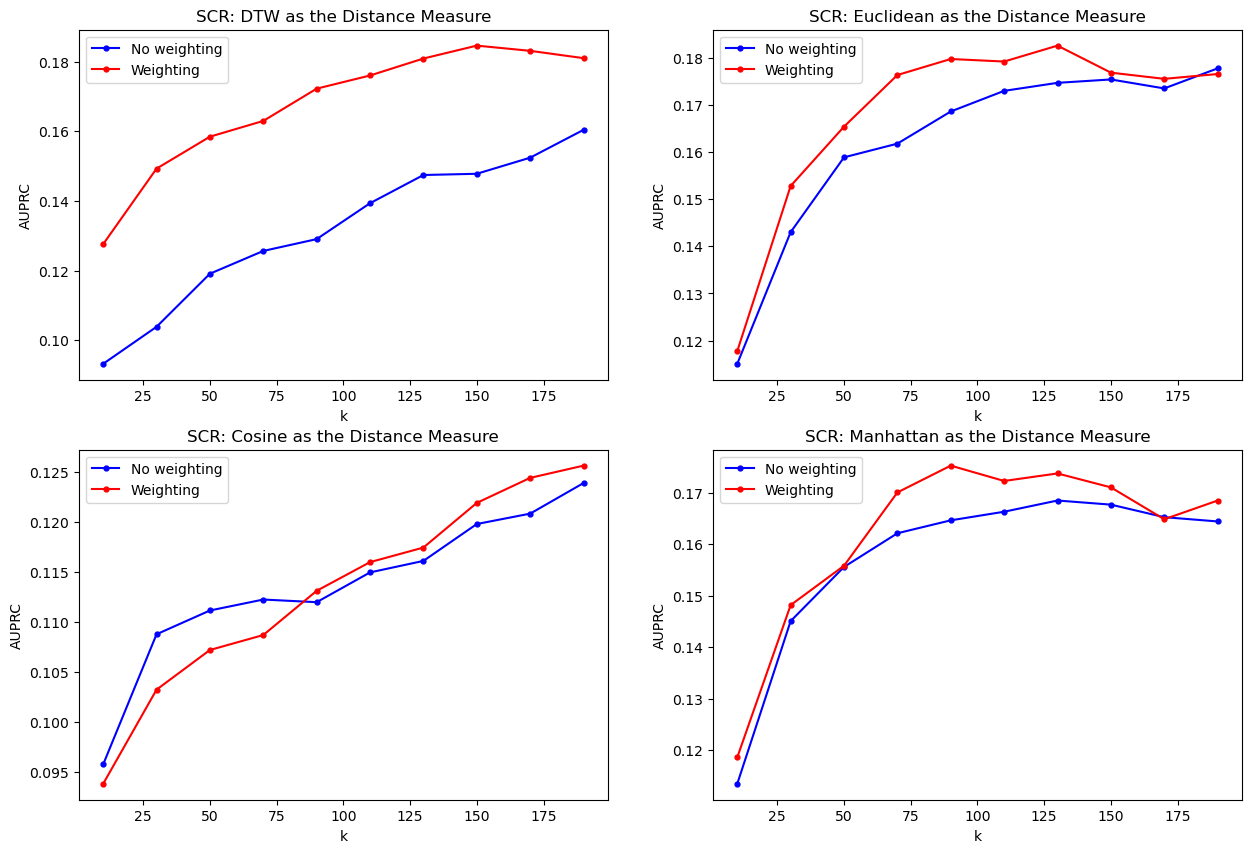

In [69]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10)) 

metric = "AUPRC"

plot_metric_along_k(axs[0,0], k_sizes_test, SCR_DTW_control_performance["NW"][metric], SCR_DTW_control_performance["WT"][metric], "SCR: DTW as the Distance Measure", metric)
plot_metric_along_k(axs[0,1], k_sizes_test, SCR_Euc_control_performance["NW"][metric], SCR_Euc_control_performance["WT"][metric], "SCR: Euclidean as the Distance Measure", metric)
plot_metric_along_k(axs[1,0], k_sizes_test, SCR_Cos_control_performance["NW"][metric], SCR_Cos_control_performance["WT"][metric], "SCR: Cosine as the Distance Measure", metric)
plot_metric_along_k(axs[1,1], k_sizes_test, SCR_Manh_control_performance["NW"][metric], SCR_Manh_control_performance["WT"][metric], "SCR: Manhattan as the Distance Measure", metric)

plt.show()

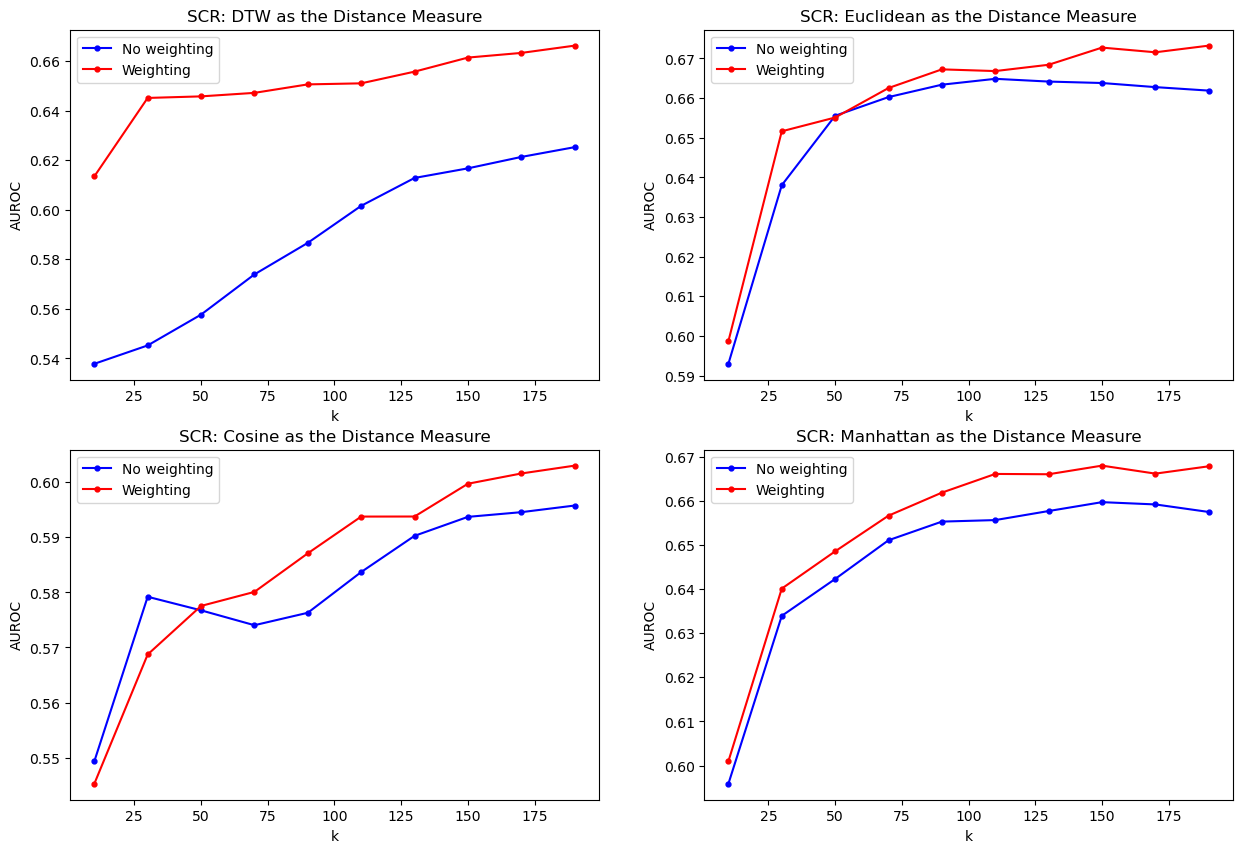

In [70]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10)) 

metric = "AUROC"

plot_metric_along_k(axs[0,0], k_sizes_test, SCR_DTW_control_performance["NW"][metric], SCR_DTW_control_performance["WT"][metric], "SCR: DTW as the Distance Measure", metric)
plot_metric_along_k(axs[0,1], k_sizes_test, SCR_Euc_control_performance["NW"][metric], SCR_Euc_control_performance["WT"][metric], "SCR: Euclidean as the Distance Measure", metric)
plot_metric_along_k(axs[1,0], k_sizes_test, SCR_Cos_control_performance["NW"][metric], SCR_Cos_control_performance["WT"][metric], "SCR: Cosine as the Distance Measure", metric)
plot_metric_along_k(axs[1,1], k_sizes_test,SCR_Manh_control_performance["NW"][metric], SCR_Manh_control_performance["WT"][metric], "SCR: Manhattan as the Distance Measure", metric)

plt.show()

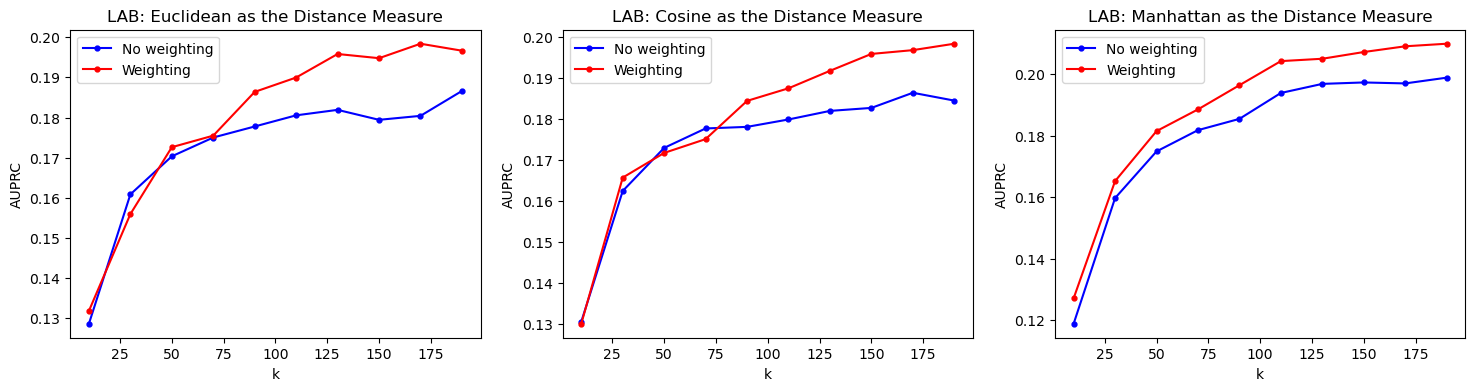

In [71]:
fig, axs = plt.subplots(1, 3, figsize=(18, 4)) 

metric = "AUPRC"

plot_metric_along_k(axs[0], k_sizes_test, LAB_Euc_control_performance["NW"][metric], LAB_Euc_control_performance["WT"][metric], "LAB: Euclidean as the Distance Measure", metric)
plot_metric_along_k(axs[1], k_sizes_test, LAB_Cos_control_performance["NW"][metric], LAB_Cos_control_performance["WT"][metric], "LAB: Cosine as the Distance Measure", metric)
plot_metric_along_k(axs[2], k_sizes_test, LAB_Manh_control_performance["NW"][metric], LAB_Manh_control_performance["WT"][metric], "LAB: Manhattan as the Distance Measure", metric)

plt.show()

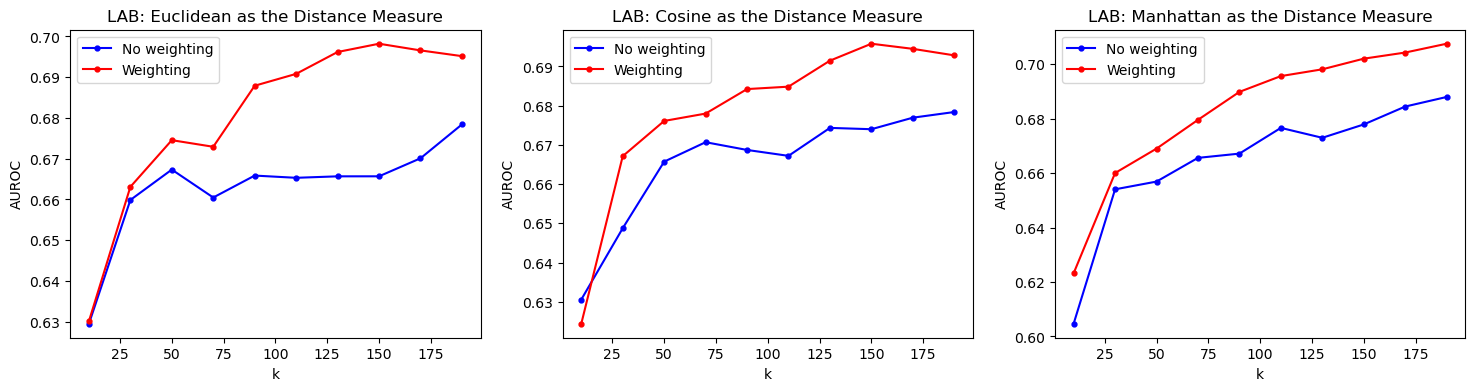

In [72]:
fig, axs = plt.subplots(1, 3, figsize=(18, 4)) 

metric = "AUROC"

plot_metric_along_k(axs[0], k_sizes_test, LAB_Euc_control_performance["NW"][metric], LAB_Euc_control_performance["WT"][metric], "LAB: Euclidean as the Distance Measure", metric)
plot_metric_along_k(axs[1], k_sizes_test, LAB_Cos_control_performance["NW"][metric], LAB_Cos_control_performance["WT"][metric], "LAB: Cosine as the Distance Measure", metric)
plot_metric_along_k(axs[2], k_sizes_test, LAB_Manh_control_performance["NW"][metric], LAB_Manh_control_performance["WT"][metric], "LAB: Manhattan as the Distance Measure", metric)

plt.show()

# Plot and Prove: Distance Measure Optimization can Improve Performance

In [73]:
def plot_optim_vs_controls(ax, k_sizes: list, control_performance: list, control_names: list, 
                           best_measure_name: str, title: str, metric: str) -> None:
    markersize = 7
    best_idx = control_names.index(best_measure_name)
    candidate_control_linecolor = ['deepskyblue', 'dodgerblue', 'skyblue', 'steelblue', 
                                   'cornflowerblue', 'royalblue', 'mediumblue', 'slateblue', 'darkblue']
    for i in range(len(control_names)):
        if i == best_idx:
            color = "red"
            alpha = 1.0
        else:
            color = candidate_control_linecolor[i]
            alpha = 0.3
        ax.plot(k_sizes, control_performance[i], label="Control - %s"%(control_names[i]), 
                marker='.', markersize=markersize, color = color, alpha = alpha)
    
    ax.set_title(title + ": " + metric)
    ax.set_xlabel('k')
    ax.set_ylabel(metric)
    ax.legend()

In [74]:
SCR_nw_control_AUPRCs = [SCR_DTW_control_performance["NW"]["AUPRC"], SCR_Euc_control_performance["NW"]["AUPRC"],
                        SCR_Cos_control_performance["NW"]["AUPRC"], SCR_Manh_control_performance["NW"]["AUPRC"]]
SCR_nw_control_AUROCs = [SCR_DTW_control_performance["NW"]["AUROC"], SCR_Euc_control_performance["NW"]["AUROC"],
                        SCR_Cos_control_performance["NW"]["AUROC"], SCR_Manh_control_performance["NW"]["AUROC"]]
SCR_wt_control_AUPRCs = [SCR_DTW_control_performance["WT"]["AUPRC"], SCR_Euc_control_performance["WT"]["AUPRC"],
                        SCR_Cos_control_performance["WT"]["AUPRC"], SCR_Manh_control_performance["WT"]["AUPRC"]]
SCR_wt_control_AUROCs = [SCR_DTW_control_performance["WT"]["AUROC"], SCR_Euc_control_performance["WT"]["AUROC"],
                        SCR_Cos_control_performance["WT"]["AUROC"], SCR_Manh_control_performance["WT"]["AUROC"]]


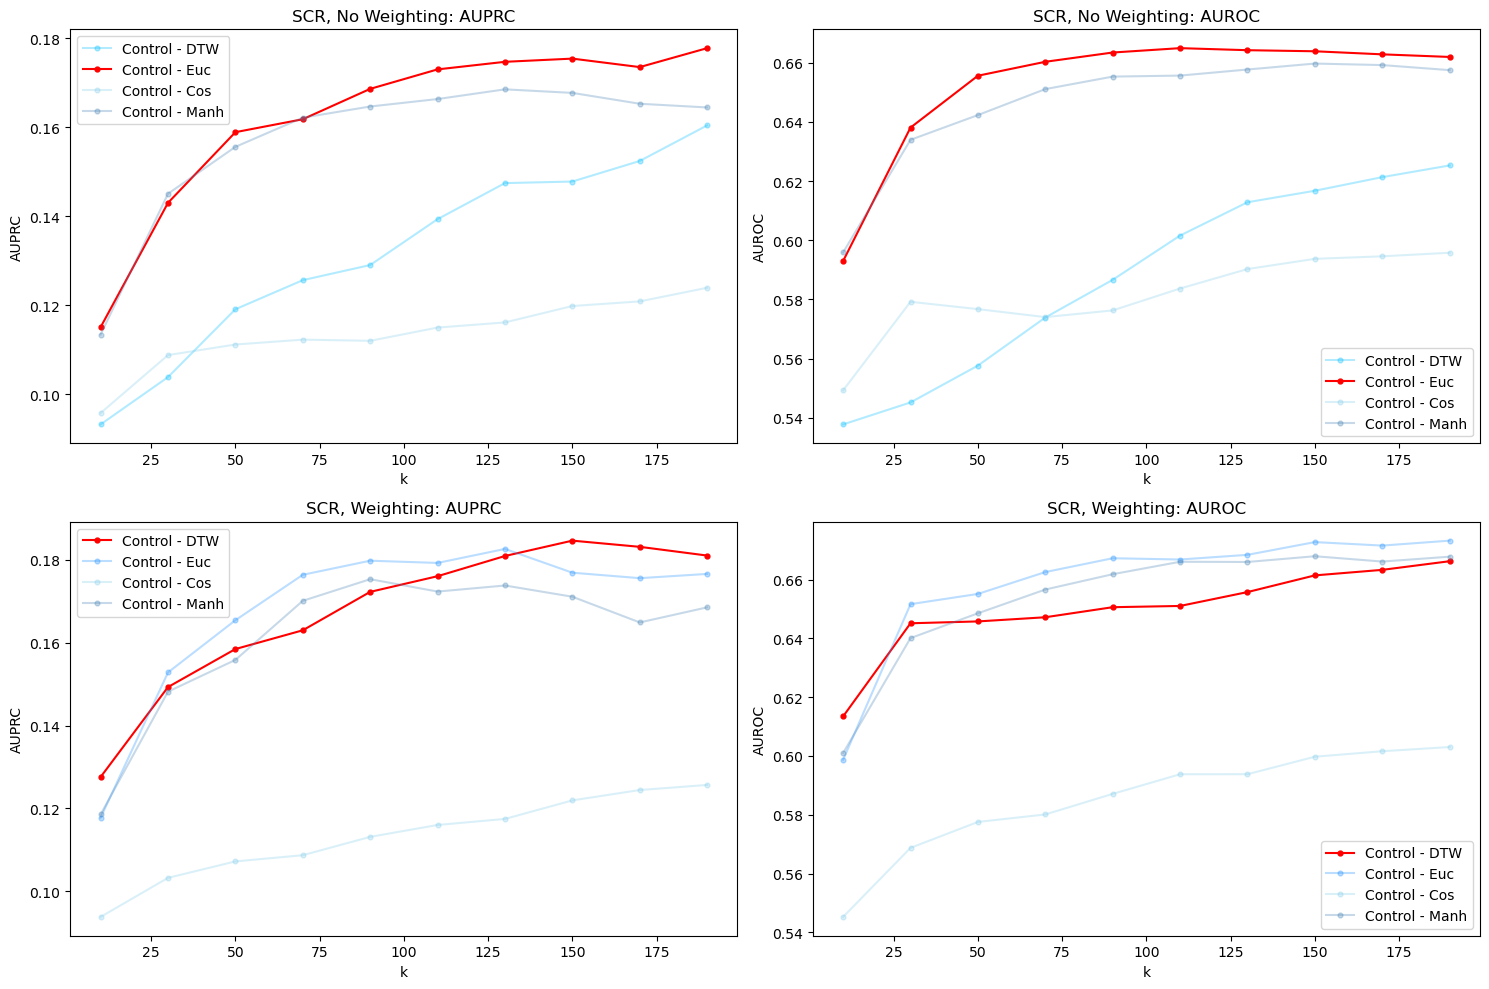

In [75]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))  # 2x2 grid of subplots, adjust the figure size as needed

plot_optim_vs_controls(axs[0, 0], k_sizes_test, SCR_nw_control_AUPRCs, ["DTW", "Euc", "Cos", "Manh"], 
                                best_distance_measures["SCR NW"], 'SCR, No Weighting', 'AUPRC')
plot_optim_vs_controls(axs[0, 1], k_sizes_test, SCR_nw_control_AUROCs, ["DTW", "Euc", "Cos", "Manh"], 
                                best_distance_measures["SCR NW"], 'SCR, No Weighting', 'AUROC')
plot_optim_vs_controls(axs[1, 0], k_sizes_test, SCR_wt_control_AUPRCs, ["DTW", "Euc", "Cos", "Manh"], 
                                best_distance_measures["SCR WT"],'SCR, Weighting', 'AUPRC')
plot_optim_vs_controls(axs[1, 1], k_sizes_test, SCR_wt_control_AUROCs, ["DTW", "Euc", "Cos", "Manh"], 
                                best_distance_measures["SCR WT"],'SCR, Weighting', 'AUROC')

plt.tight_layout()
plt.show()

In [76]:
LAB_nw_control_AUPRCs = [LAB_Euc_control_performance["NW"]["AUPRC"], LAB_Cos_control_performance["NW"]["AUPRC"], LAB_Manh_control_performance["NW"]["AUPRC"]]
LAB_nw_control_AUROCs = [LAB_Euc_control_performance["NW"]["AUROC"], LAB_Cos_control_performance["NW"]["AUROC"], LAB_Manh_control_performance["NW"]["AUROC"]]
LAB_wt_control_AUPRCs = [LAB_Euc_control_performance["WT"]["AUPRC"], LAB_Cos_control_performance["WT"]["AUPRC"], LAB_Manh_control_performance["WT"]["AUPRC"]]
LAB_wt_control_AUROCs = [LAB_Euc_control_performance["WT"]["AUROC"], LAB_Cos_control_performance["WT"]["AUROC"], LAB_Manh_control_performance["WT"]["AUROC"]]

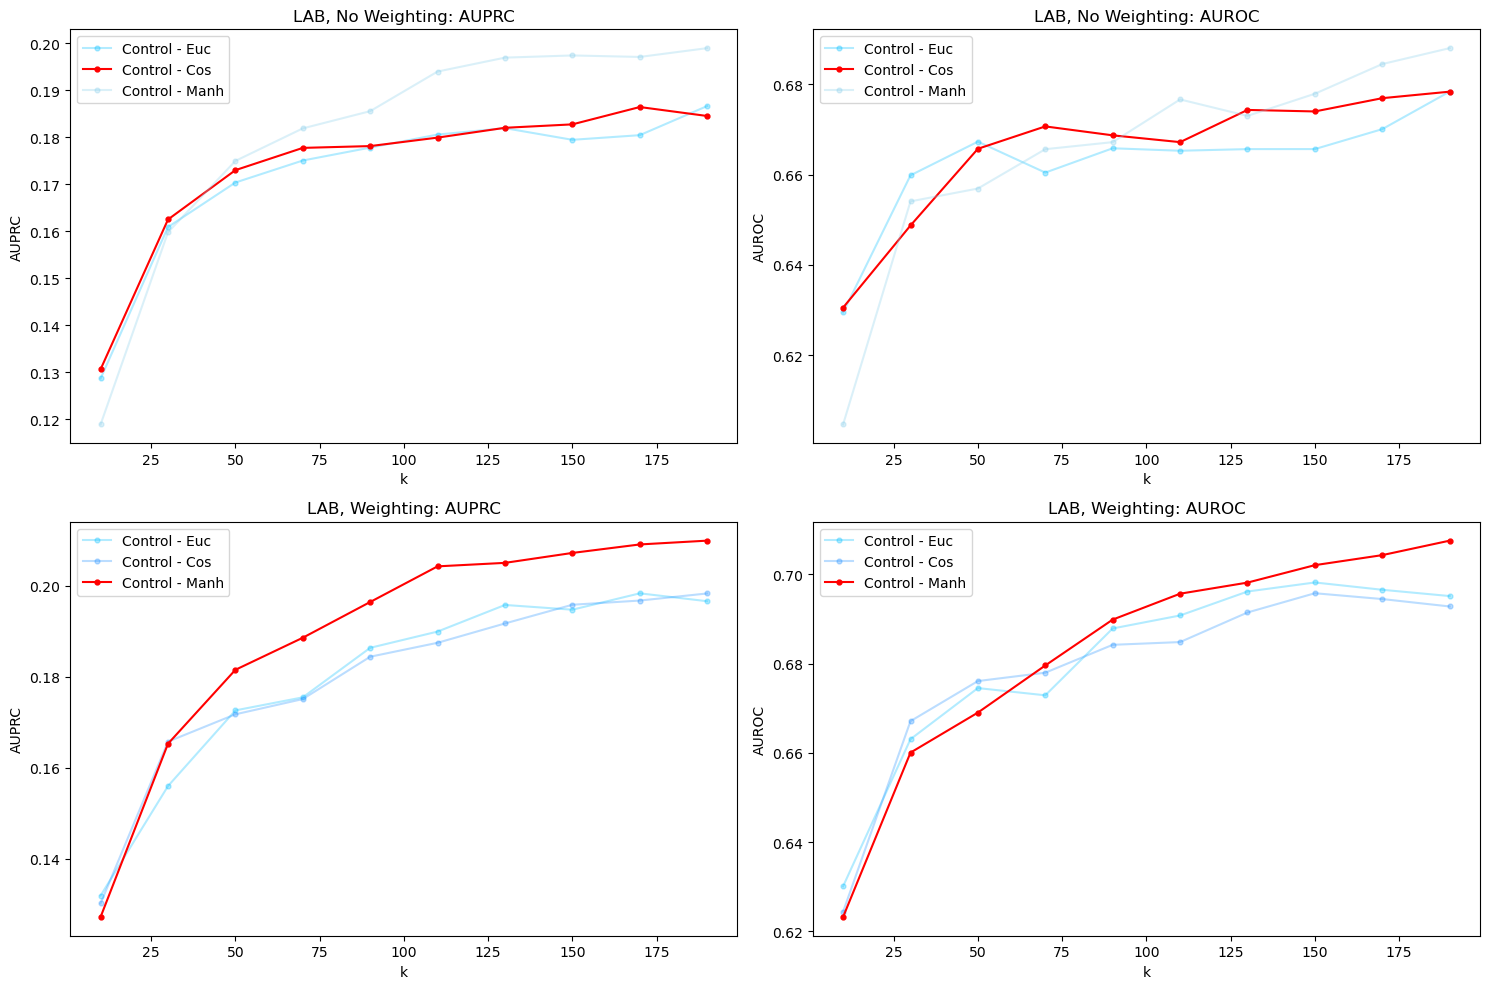

In [77]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))  # 2x2 grid of subplots, adjust the figure size as needed

plot_optim_vs_controls(axs[0, 0], k_sizes_test, LAB_nw_control_AUPRCs, ["Euc", "Cos", "Manh"], 
                                best_distance_measures["LAB NW"], 'LAB, No Weighting', 'AUPRC')
plot_optim_vs_controls(axs[0, 1], k_sizes_test, LAB_nw_control_AUROCs, ["Euc", "Cos", "Manh"], 
                                best_distance_measures["LAB NW"], 'LAB, No Weighting', 'AUROC')
plot_optim_vs_controls(axs[1, 0], k_sizes_test, LAB_wt_control_AUPRCs, ["Euc", "Cos", "Manh"], 
                                best_distance_measures["LAB WT"],'LAB, Weighting', 'AUPRC')
plot_optim_vs_controls(axs[1, 1], k_sizes_test, LAB_wt_control_AUROCs, ["Euc", "Cos", "Manh"], 
                                best_distance_measures["LAB WT"],'LAB, Weighting', 'AUROC')

plt.tight_layout()
plt.show()

# Optimize Weights to Combine Feature Types

In [78]:
opt_SCR_simi_nw_train = nw_fea_arrs_dict["SCR"][best_distance_measures["SCR NW"]]["simi"]["train"]
opt_LAB_simi_nw_train = nw_fea_arrs_dict["LAB"][best_distance_measures["LAB NW"]]["simi"]["train"]
opt_SCR_simi_wt_train = wt_fea_arrs_dict["SCR"][best_distance_measures["SCR WT"]]["simi"]["train"]
opt_LAB_simi_wt_train = wt_fea_arrs_dict["LAB"][best_distance_measures["LAB WT"]]["simi"]["train"]

opt_measure_simi_nw_train_dict = {"SCR": opt_SCR_simi_nw_train, "LAB": opt_LAB_simi_nw_train}
opt_measure_simi_wt_train_dict = {"SCR": opt_SCR_simi_wt_train, "LAB": opt_LAB_simi_wt_train}

In [79]:
# get feature type weight combination
# A is for weighting SCR, B is for LAB
weight_combines = []
for A in np.arange(0.1, 1.1, 0.1):
    for B in np.arange(0.1, 1.1, 0.1):
        if A + B == 1:
            weight_combines.append((round(A, 1), round(B, 1)))  
print(len(weight_combines))

9


Feature type weight optimization

In [80]:
def optimize_feature_type_weights(ref_measure_simi_train_dict: dict, k_sizes: list, weight_combines: list, 
                                  y_train: np.array, num_processors: int) -> list:
    results = []
    for k in tqdm(k_sizes):
        result_at_k = evaluate_feature_type_weights_at_single_k(ref_measure_simi_train_dict, k, weight_combines, y_train, num_processors)
        results.append(result_at_k)
    return results

In [81]:
# Worker function to handle all weight combinations for a single k
def evaluate_feature_type_weights_at_single_k(ref_measure_simi_train_dict: dict, k: int, 
                                              weight_combines: list, y_train: np.array, num_processors: int) -> list:
    # Get the best feature type similarity measures for the current k
    # Retrieve best similarity arrays
    SCR_simi_train, LAB_simi_train = ref_measure_simi_train_dict["SCR"], ref_measure_simi_train_dict["LAB"]
    
    assert(SCR_simi_train.shape[0] == LAB_simi_train.shape[0])
    assert(SCR_simi_train.shape[1] == LAB_simi_train.shape[1])

    best_AUPRC = 0
    best_weight_combo = None

    # Iterate over all weight combinations
    for (A, B) in weight_combines:
        # search is under no weighted voting KNN
        AUPRC, _ = evaluate_feature_type_weights(SCR_simi_train, LAB_simi_train, A, B, y_train, k, num_processors)
        if AUPRC > best_AUPRC:
            best_AUPRC = AUPRC
            best_weight_combo = (A, B)

    return [k, best_AUPRC, best_weight_combo]

In [82]:
def evaluate_feature_type_weights(SCR_simi_train, LAB_simi_train, A, B, y_train, k, num_processors):
    # weighted sum of the simi mtxs and min-max normalization 
    combined_simi_train = A * SCR_simi_train + B * LAB_simi_train
    combined_simi_train = min_max_normalization(combined_simi_train, axis = 1)
    # get the ordered idx
    combined_idx_train = fast_argsort(combined_simi_train, num_processors)
    # organize the sorted idx into dict
    _, y_train_arr_combined = process_idx_arr_for_optimizing(combined_idx_train, y_train)
    
    #evluate the KNN results
    AUPRC, AUROC = KNN(y_train_arr_combined, k, y_train)
    return AUPRC, AUROC

In [83]:
weights_performance_nw_train = optimize_feature_type_weights(opt_measure_simi_nw_train_dict, k_sizes_train, 
                                                             weight_combines, y_train, num_processors)

100%|██████████| 39/39 [13:28<00:00, 20.73s/it]


In [84]:
weights_performance_wt_train = optimize_feature_type_weights(opt_measure_simi_wt_train_dict, k_sizes_train, 
                                                             weight_combines, y_train, num_processors)

100%|██████████| 39/39 [12:56<00:00, 19.90s/it]


In [85]:
grid_search_table["COMBINE NW"] = [perf[2] for perf in weights_performance_nw_train]
grid_search_table["COMBINE WT"] = [perf[2] for perf in weights_performance_wt_train]

In [86]:
grid_search_table.to_csv("/blue/yonghui.wu/lideyi/Personalization_Methodology/grid_search_table_imput2_KNN.csv", index = True)

In [87]:
grid_search_table = pd.read_csv("/blue/yonghui.wu/lideyi/Personalization_Methodology/grid_search_table_imput2_KNN.csv", index_col = 0)

In [88]:
grid_search_table

,SCR NW,LAB NW,SCR WT,LAB WT,COMBINE NW,COMBINE WT
k,,,,,,
10,Manh,Cos,DTW,Euc,"(0.7, 0.3)","(0.9, 0.1)"
15,Euc,Cos,DTW,Cos,"(0.8, 0.2)","(0.6, 0.4)"
20,Euc,Cos,DTW,Cos,"(0.8, 0.2)","(0.6, 0.4)"
25,Euc,Cos,Euc,Cos,"(0.9, 0.1)","(0.7, 0.3)"
30,Euc,Cos,Euc,Euc,"(0.3, 0.7)","(0.7, 0.3)"
35,Euc,Cos,Euc,Euc,"(0.2, 0.8)","(0.4, 0.6)"
40,Euc,Cos,Euc,Euc,"(0.2, 0.8)","(0.7, 0.3)"
45,Euc,Cos,DTW,Euc,"(0.1, 0.9)","(0.6, 0.4)"
50,Euc,Cos,DTW,Euc,"(0.2, 0.8)","(0.6, 0.4)"


# Evaluate Feature Type Weights on Test Set

In [89]:
opt_SCR_simi_nw_full = nw_fea_arrs_dict["SCR"][best_distance_measures["SCR NW"]]["simi"]["full"]
opt_LAB_simi_nw_full = nw_fea_arrs_dict["LAB"][best_distance_measures["LAB NW"]]["simi"]["full"]
opt_SCR_simi_wt_full = wt_fea_arrs_dict["SCR"][best_distance_measures["SCR WT"]]["simi"]["full"]
opt_LAB_simi_wt_full = wt_fea_arrs_dict["LAB"][best_distance_measures["LAB WT"]]["simi"]["full"]

opt_measure_simi_nw_full_dict = {"SCR": opt_SCR_simi_nw_full, "LAB": opt_LAB_simi_nw_full}
opt_measure_simi_wt_full_dict = {"SCR": opt_SCR_simi_wt_full, "LAB": opt_LAB_simi_wt_full}

In [90]:
# these are the no nan features
X_train = pd.concat([SCR_train, LAB_train], axis = 1)
X_test = pd.concat([SCR_test, LAB_test], axis = 1)
assert X_train.shape[1] == X_test.shape[1]
# assert no nan values
assert not X_train.isnull().values.any()
assert not X_test.isnull().values.any()

In [91]:
def test_final_personalized_model(k_sizes: list, grid_search_table: pd.DataFrame, train_idx: list, test_idx: list, 
                                  y_full: np.array, y_test: np.array, opt_measure_simi_full_dict: dict, num_processors: int, weighting: bool = False) -> dict:
    results = {"AUPRC": [], "AUROC": []}
        
    # get the corresponding simi mtx
    SCR_simi_full, LAB_simi_full = opt_measure_simi_full_dict["SCR"], opt_measure_simi_full_dict["LAB"]
    
    for k in tqdm(k_sizes):
        
        best_weights = eval(get_best_weights(grid_search_table, k, weighting))
        
        A = best_weights[0]
        B = best_weights[1]
        
        combined_weights_dict = combine_best_weights_for_test(SCR_simi_full, LAB_simi_full, A, B, train_idx, test_idx, 
                                                              y_full, num_processors)
        
        AUPRC_full, AUROC_full = KNN(combined_weights_dict["label"], k, y_test)
        
        
        results["AUPRC"].append(AUPRC_full)
        results["AUROC"].append(AUROC_full)
        
    return results

In [92]:
def combine_best_weights_for_test(SCR_simi_full: np.array, LAB_simi_full: np.array, A: float, B: float, 
                                  train_idx: list, test_idx: list, y_full: np.array, num_processors: int) -> dict:   # weighted sum of the simi mtxs and min-max normalization 
    combined_simi_full = A * SCR_simi_full + B * LAB_simi_full
    combined_simi_full = min_max_normalization(combined_simi_full, axis = 1)
    # get the ordered idx
    combined_idx_full = fast_argsort(combined_simi_full, num_processors)
    # organize the sorted idx into dict
    idx_arr_test_combined, y_test_arr_combined = process_idx_arr_for_test(train_idx, test_idx, combined_idx_full, y_full)
    return {"idx": idx_arr_test_combined, "label": y_test_arr_combined}

In [93]:
def get_best_weights(grid_search_table: np.array, k: int, weighting: bool) -> str:
    if not weighting:
        return grid_search_table.loc[k, "COMBINE NW"]
    else:
        return grid_search_table.loc[k, "COMBINE WT"]

In [94]:
final_model_performance_nw = test_final_personalized_model(k_sizes_test, grid_search_table, 
                                                           train_idx, test_idx, y_full, y_test, opt_measure_simi_nw_full_dict, 
                                                           num_processors, False)

100%|██████████| 10/10 [01:22<00:00,  8.26s/it]


In [95]:
final_model_performance_wt = test_final_personalized_model(k_sizes_test, grid_search_table, 
                                                           train_idx, test_idx, y_full, y_test, opt_measure_simi_wt_full_dict, 
                                                           num_processors, True)

100%|██████████| 10/10 [01:26<00:00,  8.60s/it]


In [96]:
with open('./Results_dict/Imputation_2/final_model_performance_nw_KNN.json', 'w') as file:
    json.dump(final_model_performance_nw, file)
with open('./Results_dict/Imputation_2/final_model_performance_wt_KNN.json', 'w') as file:
    json.dump(final_model_performance_wt, file)

In [9]:
final_model_performance_nw = json.load(open('./Results_dict/Imputation_2/final_model_performance_nw_KNN.json', 'r'))
final_model_performance_wt = json.load(open('./Results_dict/Imputation_2/final_model_performance_wt_KNN.json', 'r'))

# Performance of All Feature Type Weights

In [98]:
def get_weight_control_performance(k_sizes: list, weight_combines: list, train_idx: list, 
                                   test_idx: list, y_full: np.array, y_test: np.array, 
                                   opt_measure_simi_full_dict: dict, num_processors: int) -> dict:
    results = dict()
    
    # get the corresponding simi mtx
    SCR_simi_full, LAB_simi_full = opt_measure_simi_full_dict["SCR"], opt_measure_simi_full_dict["LAB"]
    
    for (A, B) in tqdm(weight_combines):
        
        results[str((A, B))] = {"AUPRC": [], "AUROC": []}
        
        combined_weights_dict = combine_best_weights_for_test(SCR_simi_full, LAB_simi_full, A, B, 
                                                              train_idx, test_idx, y_full, num_processors) 
        for k in k_sizes:
            
            AUPRC_full, AUROC_full = KNN(combined_weights_dict["label"], k, y_test)
            
            results[str((A, B))]["AUPRC"].append(AUPRC_full)
            results[str((A, B))]["AUROC"].append(AUROC_full)
        
    return results

In [99]:
all_weights_performance_nw = get_weight_control_performance(k_sizes_test, weight_combines, 
                                                            train_idx, test_idx, y_full, y_test, 
                                                            opt_measure_simi_nw_full_dict, num_processors)

100%|██████████| 9/9 [01:19<00:00,  8.88s/it]


In [100]:
all_weights_performance_wt = get_weight_control_performance(k_sizes_test, weight_combines, 
                                                            train_idx, test_idx, y_full, y_test, 
                                                            opt_measure_simi_wt_full_dict, num_processors)

100%|██████████| 9/9 [01:18<00:00,  8.71s/it]


In [101]:
def plot_all_weights_performance(ax, k_sizes, all_weights_performance, 
                                 final_model_performance, title, metric):
    
    candidate_linecolor = ['lightblue', 'skyblue', 'deepskyblue', 
                           'dodgerblue', 'cornflowerblue', 'royalblue', 
                           'steelblue', 'mediumblue', 'darkblue', 'navy', 
                           'midnightblue', 'slateblue', 'powderblue', 'cadetblue']
    
    for i, weight_performance in enumerate(all_weights_performance.values()):
        if i == 0:
            label = "Fixed Weights"
        else:
            label = ""
            
        ax.plot(k_sizes, weight_performance[metric], alpha = 0.25, marker='.', 
                markersize=10, color = candidate_linecolor[i], label = label)
        
    ax.plot(k_sizes, final_model_performance[metric], color = "red", alpha = 1,
            label = "Dynamic Weights", marker='.', markersize=7)
        
    ax.set_title(title + ": " + metric)
    ax.set_xlabel('k')
    ax.set_ylabel(metric)
    ax.legend()

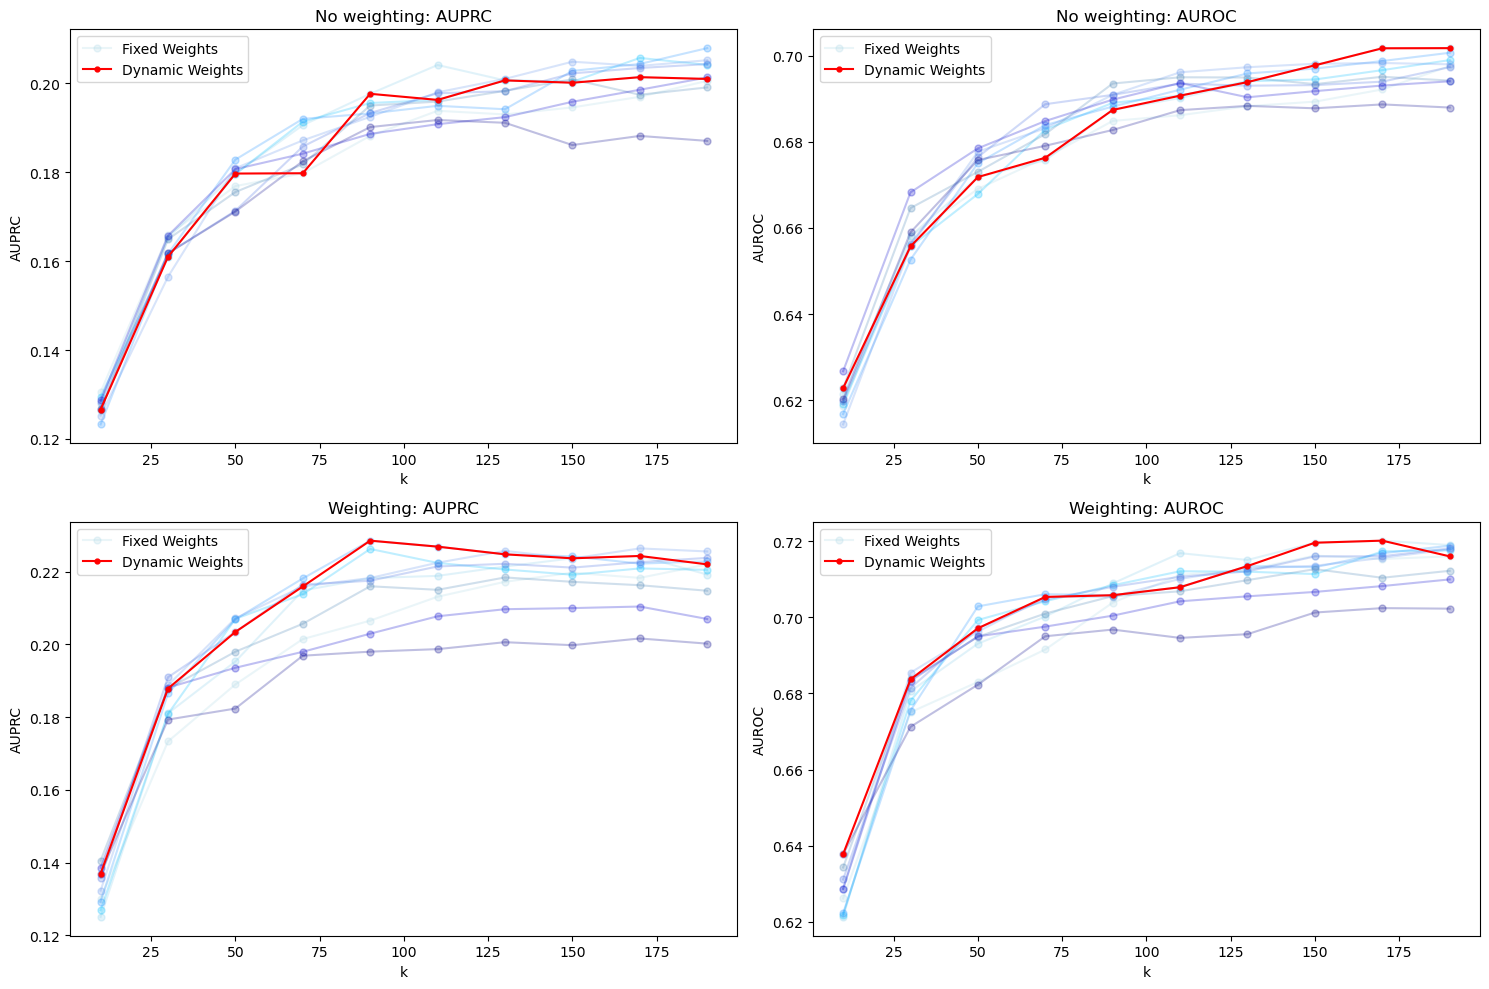

In [102]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))  # 2x2 grid of subplots, adjust the figure size as needed

plot_all_weights_performance(axs[0, 0], k_sizes_test, all_weights_performance_nw, 
                                      final_model_performance_nw, "No weighting", "AUPRC")
plot_all_weights_performance(axs[0, 1], k_sizes_test, all_weights_performance_nw, 
                                      final_model_performance_nw, "No weighting", "AUROC")
plot_all_weights_performance(axs[1, 0], k_sizes_test, all_weights_performance_wt, 
                                      final_model_performance_wt, "Weighting", "AUPRC")
plot_all_weights_performance(axs[1, 1], k_sizes_test, all_weights_performance_wt, 
                                      final_model_performance_wt, "Weighting", "AUROC")

plt.tight_layout()
plt.show()

# Baseline Models

1. Fixed Feature Type Weight (Using Weights at K = 20) with Fixed Distance Measure (Euclidean)

In [ ]:
base_k = 20
base_fix_distance_performance_nw = {"AUPRC": [], "AUROC": []}
base_fix_SCR_simi_nw_full = nw_fea_arrs_dict["SCR"]["Euc"]["simi"]["full"]
base_fix_LAB_simi_nw_full = nw_fea_arrs_dict["LAB"]["Euc"]["simi"]["full"]
A_nw, B_nw = get_best_weights(grid_search_table, base_k, False)
combined_weights_dict_nw = combine_best_weights_for_test(base_fix_SCR_simi_nw_full, base_fix_LAB_simi_nw_full, A_nw, B_nw, 
                                                      train_idx, test_idx, y_full, num_processors) 
for k in k_sizes_test:
    base_AUPRC_nw, base_AUROC_nw = KNN(combined_weights_dict_nw["label"], k, y_test)
    base_fix_distance_performance_nw["AUPRC"].append(base_AUPRC_nw)
    base_fix_distance_performance_nw["AUROC"].append(base_AUROC_nw)

2. Fixed Feature Type Weight (Using Weights at K = 20) with Best Distance Measure

In [110]:
base_fix_weights_performance_nw = all_weights_performance_nw[get_best_weights(grid_search_table, base_k, False)]
base_fix_weights_performance_wt = all_weights_performance_wt[get_best_weights(grid_search_table, base_k, True)]

# Plot the Final Performance of Personalized Models 

In [1]:
def plot_final_performance_metrics(ax, k_sizes, metric, final_model_performance_wt: dict, final_model_performance_nw: dict, 
                                   base_fix_weights_performance_nw: dict, base_fix_distance_performance_nw: dict) -> None:
    ax.plot(k_sizes, final_model_performance_wt[metric], label = "D+W+O", marker='.', markersize=7, color = "red")
    ax.plot(k_sizes, final_model_performance_nw[metric], label = "D+W", marker='.', markersize=7, color = "blue")
    ax.plot(k_sizes, base_fix_weights_performance_nw[metric], label = "D", marker='.', markersize=7, color = "cyan")
    ax.plot(k_sizes, base_fix_distance_performance_nw[metric], label = "Euclidean", marker='.', markersize=7, color = "purple")
    ax.set_title(metric + ": All Feature Performance on Test Set")
    ax.set_ylabel(metric)
    ax.set_xlabel('k')
    ax.legend()

In [2]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6)) 

plot_final_performance_metrics(axs[0], k_sizes_test, "AUPRC", final_model_performance_wt, final_model_performance_nw, base_fix_weights_performance_wt, base_fix_weights_performance_nw, base_KNN_performance)
plot_final_performance_metrics(axs[1], k_sizes_test, "AUROC", final_model_performance_wt, final_model_performance_nw, base_fix_weights_performance_wt, base_fix_weights_performance_nw, base_KNN_performance)
plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined